### Student Information

Name:`馬茂源 (Brian Ma)`

Student ID:`107062549`

GitHub ID:`brian41005`

---

### Instructions

- First, you should attempt the **take home** exercises provided in the [notebook](https://github.com/omarsar/data_mining_lab/blob/master/news_data_mining.ipynb) we used for the first lab session. Attempt all the exercises, as it is counts towards the final grade of your first assignment (20%). 

- Then, download the dataset provided in this [link](https://archive.ics.uci.edu/ml/datasets/Sentiment+Labelled+Sentences#). The sentiment dataset contains a `sentence` and `score` label. Read the specificiations of the dataset before you start exploring it. 


- Then, you are asked to apply each of the data exploration and data operation steps learned in the [first lab session](https://github.com/omarsar/data_mining_lab) on **the new dataset**. You don't need to explain all the procedures as we did in the notebook, but you are expected to provide some **minimal comments** explaining your code. You are also expected to use the same libraries used in the first lab session. You are allowed to use and modify the `helper` functions we provided in the first lab session or create your own. Also, be aware that the helper functions may need modification as you are dealing with a completely different dataset. This part is worth 30% of your grade!

- In addition to applying the same operations from the first lab, we are asking that you attempt the following tasks on the new sentiment dataset as well (40%):
    - Use your creativity and imagination to generate **new data visualizations**. Refer to online resources and the Data Mining textbook for inspiration and ideas. 
    - Generate **TF-IDF features** from the tokens of each text. Refer to this Sciki-learn [guide](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) on how you may go about doing this. Keep in mind that you are generating a matrix similar to the term-document matrix we implemented in our first lab session. However, the weights will be computed differently and should represent the TF-IDF value of each word per document as opposed to the word frequency.
    - Using both the TF-IDF and word frequency features, try to compute the **similarity** between random sentences and report results. Read the "distance simiilarity" section of the Data Mining textbook on what measures you can use here. [Cosine similarity](https://jamesmccaffrey.wordpress.com/2017/03/29/the-cosine-similarity-of-two-sentences/) is one of these methods but there are others. Try to explore a few of them in this exercise and report the differences in result. 
    - Lastly, implement a simple **Naive Bayes classifier** that automatically classifies the records into their categories. Try to implement this using scikit-learn built in classifiers and use both the TF-IDF features and word frequency features to build two seperate classifiers. Refer to this [nice article](https://hub.packtpub.com/implementing-3-naive-bayes-classifiers-in-scikit-learn/) on how to build this type of classifier using scikit-learn. Report the classification accuracy of both your models. If you are struggling with this step please reach us on Slack as soon as possible.   


- Presentation matters! You are also expected to **tidy up your notebook** and attempt new data operations and techniques that you have learned so far in the Data Mining course. Surprise us! This segment is worth 10% of your grade. The idea of this exercise is to begin thinking of how you will program the concepts you have learned and the process that is involved. 


- After completing all the above tasks, you are free to remove this header block and **submit** your assignment following the guide provided in the [README.md](https://github.com/omarsar/dm_2018_hw_1/blob/master/README.md) file of the assignment's repository. 

In [1]:
### Begin Assignment Here!

In [2]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import matplotlib.pyplot as plt
%matplotlib inline

/usr/local/lib/python3.7/site-packages/sklearn/utils/__init__.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence


## Load data

In [3]:
file_list = ['imdb_labelled', 'yelp_labelled' , 'amazon_cells_labelled']

In [4]:
sentiment_df = pd.concat([pd.read_csv('sentiment labelled sentences/{}.txt'.format(f_name), 
                                      sep='\t', 
                                      header=None)  
                          for f_name in file_list])
sentiment_df.columns = ['text', 'score']

In [5]:
sentiment_df.head()

,text,score
0,"A very, very, very slow-moving, aimless movie ...",0
1,Not sure who was more lost - the flat characte...,0
2,Attempting artiness with black & white and cle...,0
3,Very little music or anything to speak of.,0
4,The best scene in the movie was when Gerardo i...,1


In [6]:
len(sentiment_df)

2748

In [7]:
sentiment_df[['score']].describe()

,score
count,2748.000000
mean,0.504367
std,0.500072
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


## Check Missing values

In [8]:
sentiment_df.isnull().sum()

text     0
score    0
dtype: int64

In [9]:
sentiment_df['text'].apply(lambda t: t == None 
                           and t == np.nan 
                           and t == '').sum()

0

In [10]:
sentiment_df['score'].apply(lambda s: not(s == 0 or s == 1)).sum()

0

## Duplicate Data

In [11]:
sentiment_df.duplicated('text').sum()

17

In [12]:
sentiment_df['text'][sentiment_df.duplicated('text', False)]

29                      Definitely worth checking out.  
64                                               10/10  
165                     Definitely worth checking out.  
374                                   Not recommended.  
387                                   Not recommended.  
590                                              10/10  
334                                   I love this place.
380                                     I won't be back.
383                               The food was terrible.
505                    I would not recommend this place.
814                                   I love this place.
816                               The food was terrible.
843                                     I won't be back.
846                    I would not recommend this place.
18                                         Works great!.
179    If you like a loud buzzing to override all you...
180                              Don't buy this product.
187                            

In [13]:
sentiment_df.drop_duplicates('text', inplace=True)

In [14]:
len(sentiment_df) == 2731

True

## Data Preprocessing

1    1376
0    1355
Name: score, dtype: int64


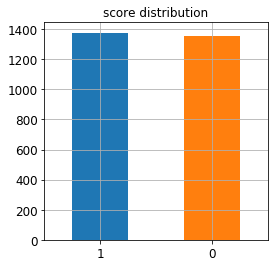

In [15]:
value_counts = sentiment_df['score'].value_counts()
print(value_counts)
value_counts.plot(kind = 'bar',
                  grid=True,
                  title = 'score distribution',
                  rot = 0, fontsize = 12, figsize = (4, 4))

In [16]:
#dataset is balance.

## Generate  features

In [17]:
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.preprocessing import normalize

### TF-IDF

In [18]:
tfidf_vectorizer = TfidfVectorizer()

In [19]:
X_tfidf = tfidf_vectorizer.fit_transform(sentiment_df['text'])
X_tfidf = normalize(X_tfidf, axis=1)
X_tfidf.shape

(2731, 5155)

#### TF-IDF Similarity visualizations

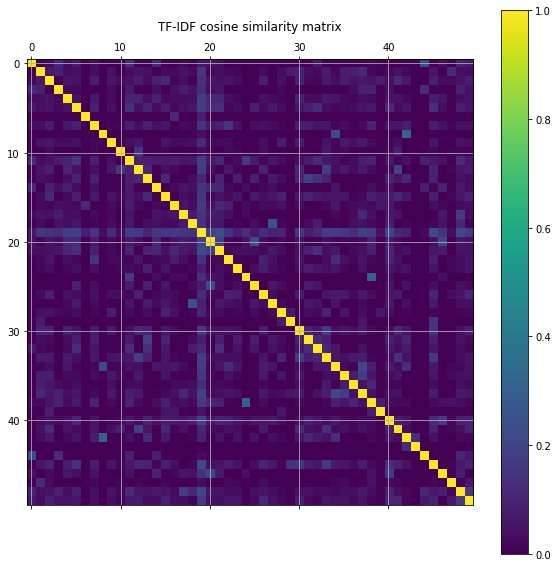

In [20]:
fig, ax = plt.subplots(figsize=(10, 10))
cax = ax.matshow(cosine_similarity(X_tfidf)[:50,:50], 
                 interpolation='nearest')
ax.grid(True)
plt.title('TF-IDF cosine similarity matrix')
fig.colorbar(cax)
plt.show()

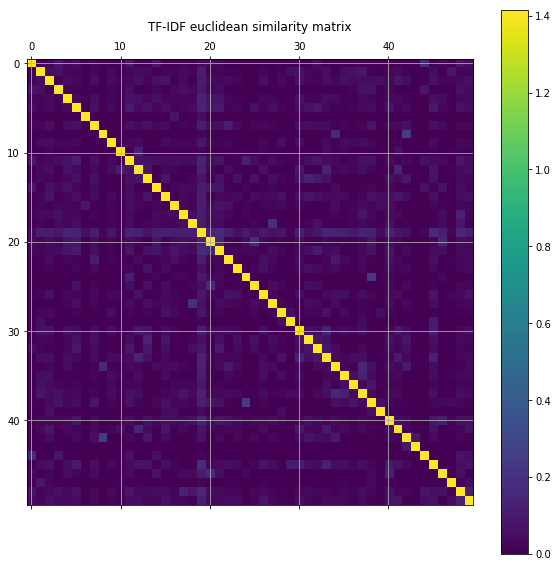

In [21]:
fig, ax = plt.subplots(figsize=(10, 10))
cax = ax.matshow(np.sqrt(2) - euclidean_distances(X_tfidf)[:50,:50], 
                 interpolation='nearest')
ax.grid(True)
plt.title('TF-IDF euclidean similarity matrix')
fig.colorbar(cax)
plt.show()

### TF features

In [22]:
tf_vectorizer = CountVectorizer()

In [23]:
X_tf = tf_vectorizer.fit_transform(sentiment_df['text'])
X_tf = normalize(X_tf, axis=1)
X_tf.shape

(2731, 5155)

#### TF VS Doc

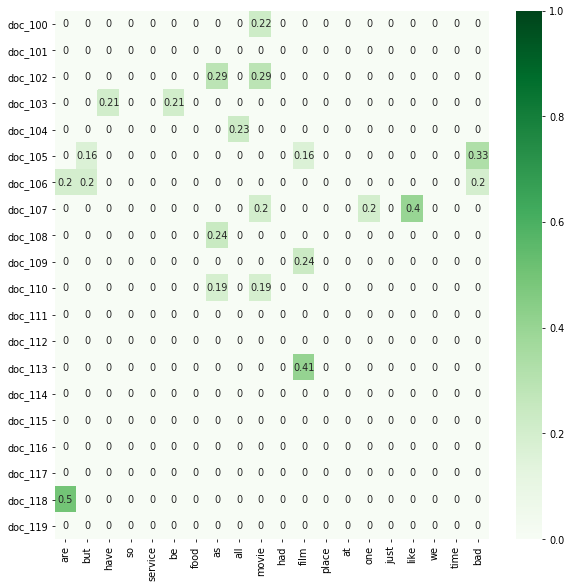

In [40]:
words_idx = np.argsort(np.sum(X_tf, axis=0).tolist()[0])[::-1][20:40]
plot_x = [tf_vectorizer.get_feature_names()[i] for i in words_idx]
doc_idx = slice(100, 120)
plot_y = ["doc_"+ str(i) for i in list(sentiment_df.index)[doc_idx]]
plot_z = X_tf[doc_idx, words_idx].toarray()
df_todraw = pd.DataFrame(plot_z, columns = plot_x, index = plot_y)
plt.subplots(figsize=(10, 10), dpi=70)
sns.heatmap(df_todraw, vmin=0, vmax=1, annot=True, cmap="Greens")

#### TF Similarity visualizations

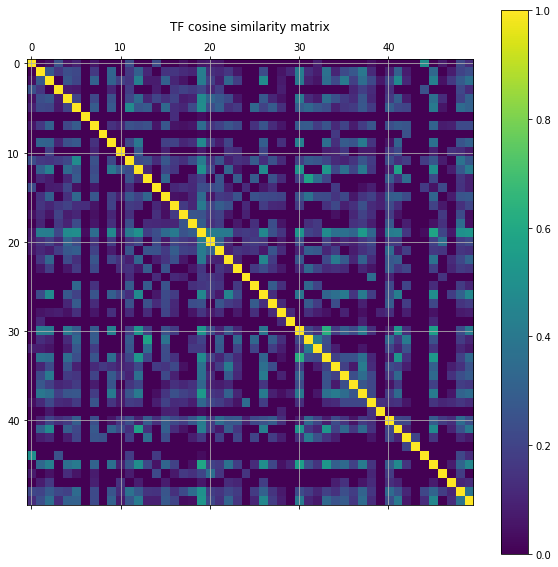

In [41]:
fig, ax = plt.subplots(figsize=(10, 10))
cax = ax.matshow(cosine_similarity(X_tf)[:50,:50], 
                 interpolation='nearest')
ax.grid(True)
plt.title('TF cosine similarity matrix')
fig.colorbar(cax)
plt.show()

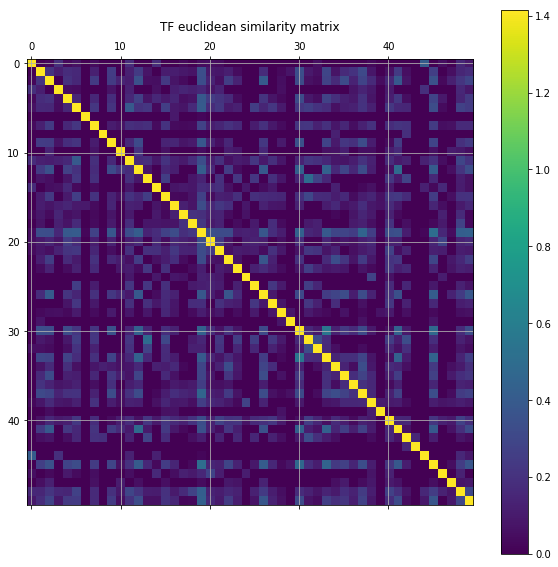

In [42]:
fig, ax = plt.subplots(figsize=(10, 10))
cax = ax.matshow(np.sqrt(2) - euclidean_distances(X_tf)[:50,:50], 
                 interpolation='nearest')
ax.grid(True)
plt.title('TF euclidean similarity matrix')
fig.colorbar(cax)
plt.show()

## Features  Visualizations

In [ ]:
plot_x = ["term_"+str(i) for i in count_vect.get_feature_names()[0:20]]
plot_y = ["doc_"+ str(i) for i in list(X.index)[0:20]]
plot_z = X_counts[0:20, 0:20].toarray()
import seaborn as sns

df_todraw = pd.DataFrame(plot_z, columns = plot_x, index = plot_y)
plt.subplots(figsize=(9, 7))
ax = sns.heatmap(df_todraw,
                 cmap="PuRd",
                 vmin=0, vmax=1, annot=True)

In [255]:
from sklearn.decomposition import KernelPCA, TruncatedSVD, FactorAnalysis

### Dimension reduction

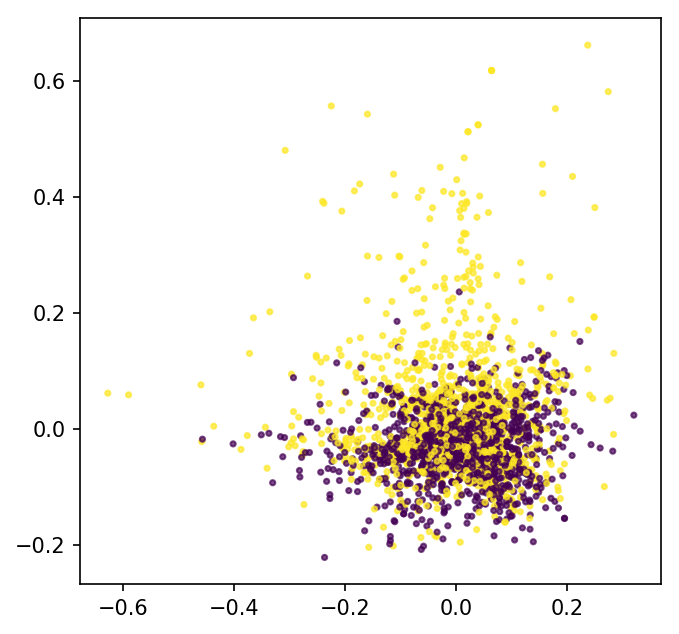

In [259]:
pca = KernelPCA(n_components=2, random_state=42)
#TF IDF
X_tfidf_reduced = pca.fit_transform(X_tfidf)
plt.figure(figsize=(5, 5), dpi=150)
plt.scatter(X_tfidf_reduced[:, 0], X_tfidf_reduced[:, 1], 
            c=sentiment_df['score'].values.tolist(),
            s=6, alpha=0.7)

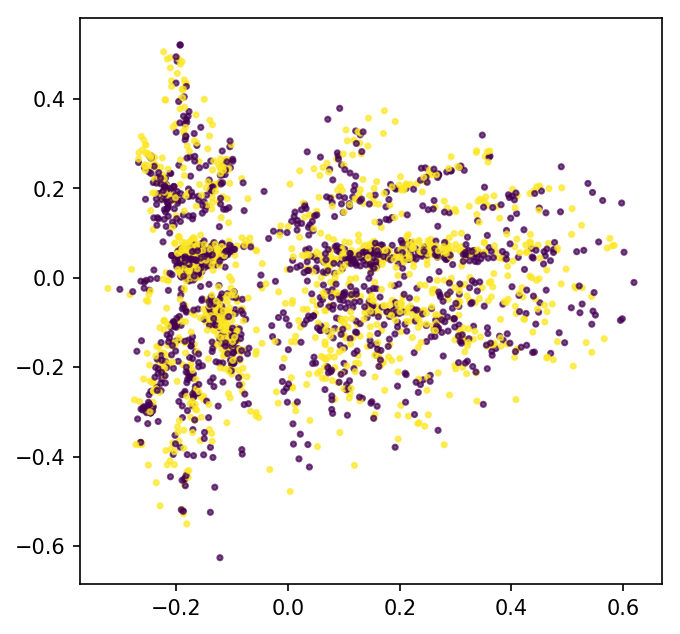

In [121]:
pca = KernelPCA(n_components=2, random_state=42)
#TF
X_tf_reduced = pca.fit_transform(X_tf)
plt.figure(figsize=(5, 5), dpi=150)
plt.scatter(X_tf_reduced[:, 0], X_tf_reduced[:, 1], 
            c=sentiment_df['score'].values.tolist(),
            s=6, alpha=0.7)

In [122]:
# It seems that 2D is not good for separating data.

In [125]:
y = sentiment_df['score'].values.tolist()

### Word Cloud

In [ ]:
sentiment_df[sentiment_df['score'] == 1]['text']

### Term Frequency

## Classifying 

In [278]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import cross_val_score, cross_val_predict

In [271]:
X_tfidf_dense = X_tfidf.toarray()
X_tf_dense = X_tf.toarray()

In [283]:
model = MultinomialNB()

### TF-IDF

In [284]:
cross_val_score(model, X_tfidf_dense, y, scoring='accuracy', cv=10, n_jobs=-1).mean()

0.8187770911284222

In [285]:
y_pred = cross_val_predict(model, X_tfidf_dense, y, cv=10, n_jobs=-1)
print(classification_report(y, y_pred))

             precision    recall  f1-score   support

          0       0.82      0.82      0.82      1355
          1       0.82      0.82      0.82      1376

avg / total       0.82      0.82      0.82      2731



### TF

In [286]:
cross_val_score(model, X_tf_dense, y, scoring='accuracy', cv=10, n_jobs=-1).mean()

0.8092800188576273

In [287]:
y_pred = cross_val_predict(model, X_tf_dense, y, cv=10, n_jobs=-1)
print(classification_report(y, y_pred))

             precision    recall  f1-score   support

          0       0.80      0.81      0.81      1355
          1       0.82      0.80      0.81      1376

avg / total       0.81      0.81      0.81      2731

